In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')



In [2]:
from rl.berkeleyrlcourse.hw1.dagger import *

os.chdir('/home/z/code/blaze_root/src/rl/berkeleyrlcourse/hw1')


[2018-01-30 00:07:11,045] Making new env: Hopper-v1


From expert_rollouts/Hopper-v1/n100_1.pkl
Loaded observations: (100000, 11)
Loaded actions: (100000, 3)


Step: 0; Loss: 2.1155316829681396; R: 24.928877543442347


Step: 1000; Loss: -0.9769235849380493; R: 443.30242751024707


Step: 2000; Loss: 0.008093697018921375; R: 133.92520692569684


Step: 3000; Loss: -1.4321105480194092; R: 318.838101154019


Step: 4000; Loss: -1.2975085973739624; R: 301.8635026349467


Step: 5000; Loss: -0.7477947473526001; R: 375.7201697565117


Step: 6000; Loss: -1.9393614530563354; R: 825.0482100814557


Step: 7000; Loss: -2.2945799827575684; R: 1250.9167002753923


Step: 8000; Loss: -2.593684434890747; R: 1707.517338146227


Step: 9000; Loss: -2.5837292671203613; R: 2096.1830723324138


Step: 10000; Loss: -2.491276264190674; R: 1347.230059870312


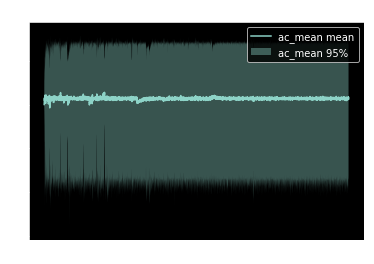

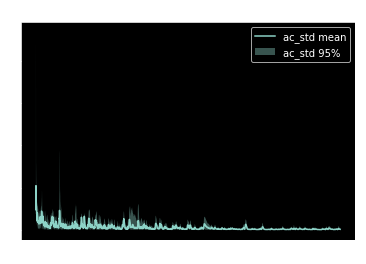

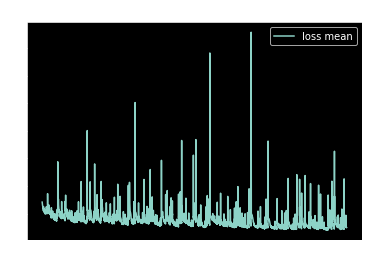

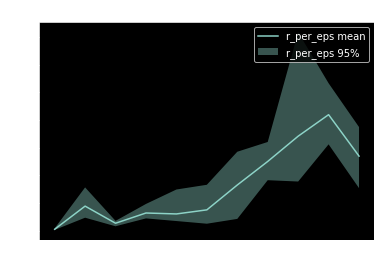

In [3]:
env_name = 'Hopper-v1'
train_params = TrainParams(
  num_steps=10001,  # was 50001
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [6]:
# Show an episode of the imitation policy
exps['Hopper-v1'].visualize()

Step: 9000. Expected reward: 2096.1830723324138


Reward: mean 2005.93, std 0.00 over 1 episodes.
Actual rewards: [[2005.9259135264022]]


[2018-01-28 15:57:57,557] Making new env: Ant-v1


From expert_rollouts/Ant-v1/n100_1.pkl
Loaded observations: (99265, 111)
Loaded actions: (99265, 8)


Step: 0; Loss: 0.9847607612609863; R: -151.77329358631576


Step: 500; Loss: -1.3151004314422607; R: 1681.87907295859


Step: 1000; Loss: -1.7115744352340698; R: 2558.3156335833964


Step: 1500; Loss: -1.0086281299591064; R: 2046.059611866281


Step: 2000; Loss: -2.2359673976898193; R: 4508.198844356931


Step: 2500; Loss: -2.275665044784546; R: 4605.052511556383


Step: 3000; Loss: -1.1410953998565674; R: 2600.7918178921436


Step: 3500; Loss: -2.3655385971069336; R: 4684.915156948217


Step: 4000; Loss: -2.3895716667175293; R: 4906.461464886893


Step: 4500; Loss: -2.644102096557617; R: 4679.617127763602


Step: 5000; Loss: -2.355576515197754; R: 3857.043140715893


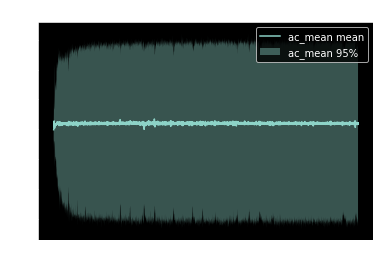

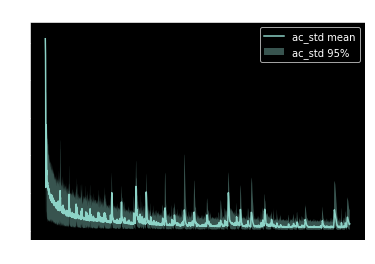

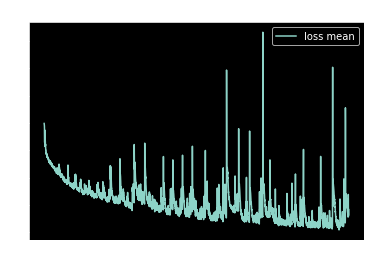

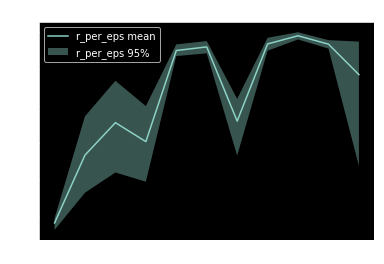

In [45]:
env_name = 'Ant-v1'
train_params = TrainParams(
  num_steps=5001,
  mini_batch_size=500,
  steps_per_policy_eval=500,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



In [51]:
# Show an episode of the imitation policy
exps['Ant-v1'].visualize()


Reward: mean 4023.41, std 0.00 over 1 episodes.
Actual rewards: [[4023.407596137964]]


[2018-01-28 16:38:12,691] Making new env: HalfCheetah-v1


From expert_rollouts/HalfCheetah-v1/n100_1.pkl
Loaded observations: (100000, 17)
Loaded actions: (100000, 6)


Step: 0; Loss: 1.2086057662963867; R: -607.7744736737343


Step: 300; Loss: -0.5447344779968262; R: 698.2046435481374


Step: 600; Loss: -0.8952125906944275; R: 2428.9333138958496


Step: 900; Loss: -0.7336575388908386; R: 3208.810203674052


Step: 1200; Loss: -1.3893944025039673; R: 4109.279475422539


Step: 1500; Loss: -1.0110143423080444; R: 2842.867525299743


Step: 1800; Loss: -1.6141037940979004; R: 4059.0456537475984


Step: 2100; Loss: -1.7782347202301025; R: 4074.949499606453


Step: 2400; Loss: -1.8222477436065674; R: 4034.4159103549196


Step: 2700; Loss: -2.034633159637451; R: 4215.293752178581


Step: 3000; Loss: -1.7886015176773071; R: 4187.4791127358


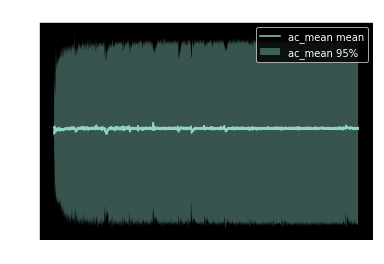

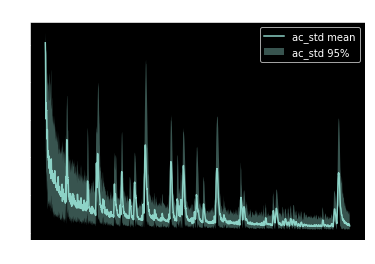

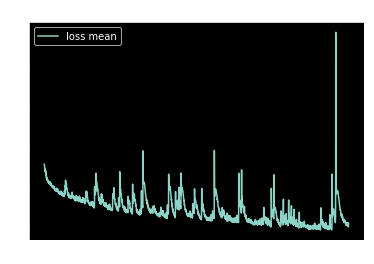

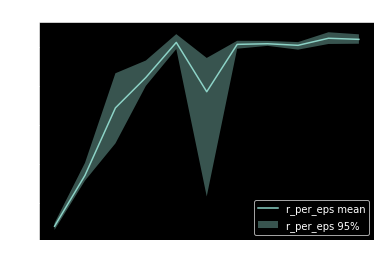

In [74]:
env_name = 'HalfCheetah-v1'
train_params = TrainParams(
  num_steps=3001,
  mini_batch_size=500,
  steps_per_policy_eval=300,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



In [78]:
# Show an episode of the imitation policy
exps['HalfCheetah-v1'].visualize()


Step: 2700. Expected reward: 4215.293752178581


Reward: mean 4058.18, std 0.00 over 1 episodes.
Actual rewards: [[4058.181733072296]]


[2018-01-28 17:06:25,366] Making new env: Reacher-v1


From expert_rollouts/Reacher-v1/n100_1.pkl
Loaded observations: (5000, 11)
Loaded actions: (5000, 2)


Step: 0; Loss: 0.9691274762153625; R: -119.82116379870293


Step: 500; Loss: -3.092132091522217; R: -6.8078993400522


Step: 1000; Loss: -3.4575321674346924; R: -5.844205020442443


Step: 1500; Loss: -3.8899197578430176; R: -5.533290657269859


Step: 2000; Loss: -4.151736736297607; R: -5.375476685048888


Step: 2500; Loss: -3.9934866428375244; R: -5.557228806464453


Step: 3000; Loss: -4.809988975524902; R: -4.317785394067953


Step: 3500; Loss: -4.854434967041016; R: -4.325570173061233


Step: 4000; Loss: -1.7176358699798584; R: -8.970584913505183


Step: 4500; Loss: -4.516554832458496; R: -4.379245931791329


Step: 5000; Loss: -5.100255489349365; R: -6.246827517963335


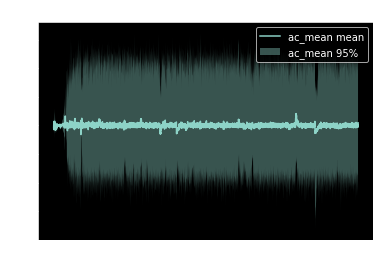

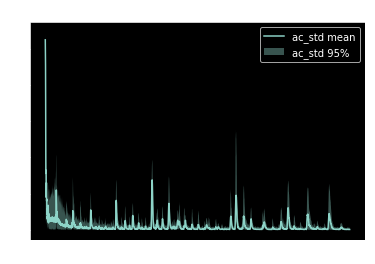

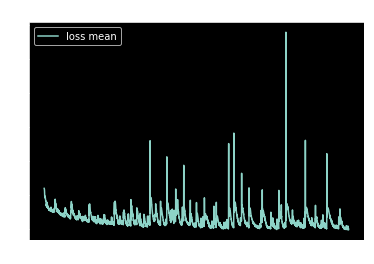

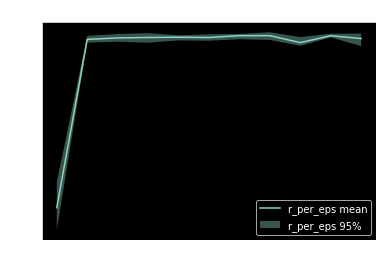

In [79]:
env_name = 'Reacher-v1'
train_params = TrainParams(
  num_steps=5001,
  mini_batch_size=500,
  steps_per_policy_eval=500,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [81]:
# Show an episode of the imitation policy
exps['Reacher-v1'].visualize(num_episodes=10)


Step: 3000. Expected reward: -4.317785394067953


Reward: mean -2.99, std 2.14 over 10 episodes.
Actual rewards: [[-2.83541853460701, -1.5761261735392216, -3.5030861061711596, -1.1703574922295308, -8.49789970747889, -3.9383509960206418, -3.4527570976892252, -0.7453823239240847, -1.070279844746793, -3.131126451155939]]


[2018-01-28 23:18:51,530] Making new env: Walker2d-v1


From expert_rollouts/Walker2d-v1/n20_1.pkl
Loaded observations: (20000, 17)
Loaded actions: (20000, 6)
Step: 0; Loss: 1.586344838142395; R: 1.0520117176755381


Step: 1000; Loss: -0.6223083734512329; R: 217.04206845715643


Step: 2000; Loss: -0.3530205190181732; R: 327.3809076069482


Step: 3000; Loss: -1.3627867698669434; R: 761.0991818610989


Step: 4000; Loss: -1.003460168838501; R: 985.5182118809195


Step: 5000; Loss: -1.2768322229385376; R: 1118.7555073053938


Step: 6000; Loss: -1.866660475730896; R: 993.9717602940298


Step: 7000; Loss: -1.3819140195846558; R: 1608.1169530315717


Step: 8000; Loss: -1.9412869215011597; R: 1088.6571267769957


Step: 9000; Loss: -1.665181279182434; R: 1670.2678093013685


Step: 10000; Loss: -1.721450686454773; R: 1854.0451077092898


Step: 11000; Loss: -1.6400388479232788; R: 2957.921545378157


Step: 12000; Loss: -1.8305606842041016; R: 2194.6040790587776


Step: 13000; Loss: -1.509121298789978; R: 2228.492046577171


Step: 14000; Loss: -0.29788267612457275; R: 702.2173956464296


Step: 15000; Loss: -1.5458827018737793; R: 1995.5609866686912


Step: 16000; Loss: -1.8170942068099976; R: 1419.9148425973572


Step: 17000; Loss: -1.7343240976333618; R: 1706.3597978775383


Step: 18000; Loss: -1.4099839925765991; R: 2832.824162035092


Step: 19000; Loss: -2.030876874923706; R: 1168.858378552636


Step: 20000; Loss: -1.1459006071090698; R: 1164.5750382712474


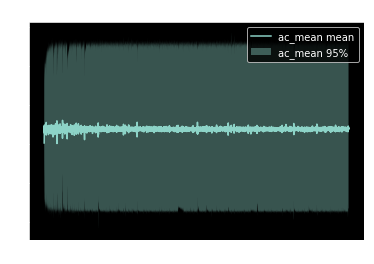

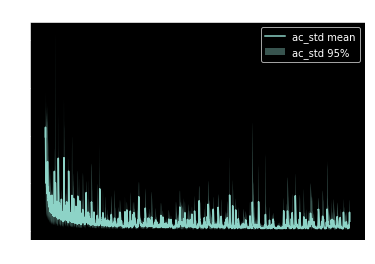

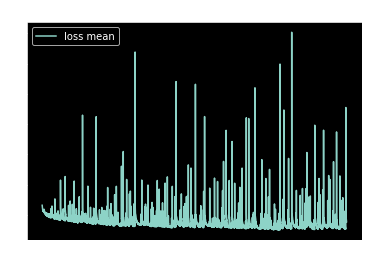

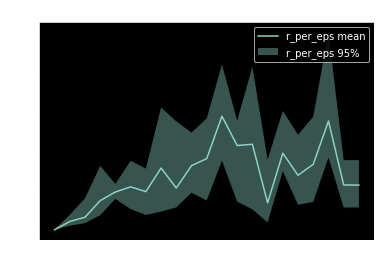

In [91]:
env_name = 'Walker2d-v1'
train_params = TrainParams(
  num_steps=20001,
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [92]:
# Show an episode of the imitation policy
exps['Walker2d-v1'].visualize()


Step: 11000. Expected reward: 2957.921545378157


Reward: mean 4281.39, std 0.00 over 1 episodes.
Actual rewards: [[4281.394595676173]]


[2018-01-30 00:16:07,746] Making new env: Humanoid-v1


From expert_rollouts/Humanoid-v1/n100_1.pkl
Loaded observations: (100000, 376)
Loaded actions: (100000, 17)


Step: 0; Loss: 1.5180984735488892; R: 146.25498662395833


Step: 1000; Loss: -0.2452545166015625; R: 411.7631882267353


Step: 2000; Loss: -0.4682508707046509; R: 465.00376115318505


Step: 3000; Loss: -0.6283194422721863; R: 537.3375060334349


Step: 4000; Loss: -0.7685666084289551; R: 683.1659977188481


Step: 5000; Loss: -0.743048906326294; R: 713.2592034369356


Step: 6000; Loss: -0.8227756023406982; R: 643.6742906083045


Step: 7000; Loss: -0.8937227725982666; R: 619.6665444608268


Step: 8000; Loss: -1.0027046203613281; R: 812.0088179172295


Step: 9000; Loss: -0.8369324207305908; R: 656.9940208079772


Step: 10000; Loss: -1.041055679321289; R: 702.2890211187417


Step: 11000; Loss: -1.055638313293457; R: 2913.0772561577874


Step: 12000; Loss: -0.567426860332489; R: 732.513589913808


Step: 13000; Loss: -0.8247917294502258; R: 693.8032528992268


Step: 14000; Loss: -0.9410641193389893; R: 1370.5736353602863


Step: 15000; Loss: -0.9739455580711365; R: 1777.6017046293969


Step: 16000; Loss: -1.0069912672042847; R: 1148.21009296831


Step: 17000; Loss: -1.074615240097046; R: 2577.618596189419


Step: 18000; Loss: -1.1429686546325684; R: 1950.6281614869


Step: 19000; Loss: -1.123795986175537; R: 2825.439069457241


Step: 20000; Loss: -1.1161227226257324; R: 3602.8994096407832


Step: 21000; Loss: -1.1543898582458496; R: 5849.200928820628


Step: 22000; Loss: -1.2731022834777832; R: 3755.9850660012426


Step: 23000; Loss: -1.1415711641311646; R: 5749.532619608273


Step: 24000; Loss: -1.2481104135513306; R: 7295.443867355937


Step: 25000; Loss: 0.40053361654281616; R: 392.5925263415461


Step: 26000; Loss: -0.12460002303123474; R: 331.6840358081744


Step: 27000; Loss: -0.3483332097530365; R: 384.20293122138764


Step: 28000; Loss: -0.46268048882484436; R: 448.70946585245747


Step: 29000; Loss: -0.5429996252059937; R: 522.3499991177848


Step: 30000; Loss: -0.6512494683265686; R: 406.78331862937574


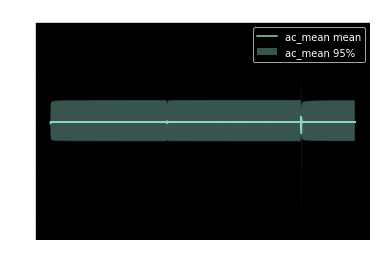

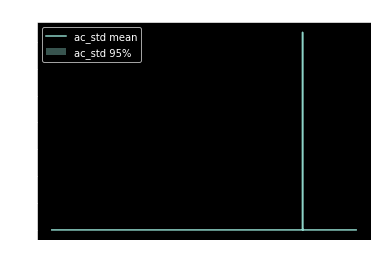

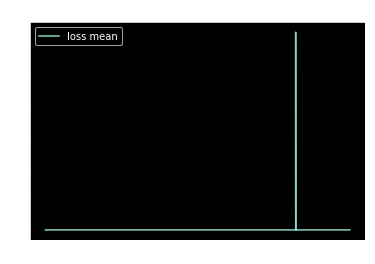

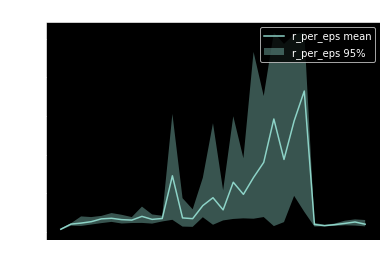

In [7]:
env_name = 'Humanoid-v1'
train_params = TrainParams(
  num_steps=30001,
  mini_batch_size=1000,
  steps_per_policy_eval=1000,
  policy_eval_eps=5,
  lr=0.001
)
model_params = {
  'shared_layers': (256,) * 5,
  'action_layers': (256,) * 3,
  'model_std': True,
  'min_std': None,
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()



In [8]:
# Show an episode of the imitation policy
exps['Humanoid-v1'].visualize()


Step: 24000. Expected reward: 7295.443867355937


Reward: mean 10156.79, std 0.00 over 1 episodes.
Actual rewards: [[10156.792988241956]]
